# Model Training and Evalution

## LightFM Model

`lightfm` is an advanced matrix factorization library for
recommender systems. We are using it for its logistic loss
feature which has good performance on $[-1, 1]$ interaction
matrices.

In [1]:
import copy
import itertools

import joblib
import lightfm
import lightfm.evaluation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import sklearn.model_selection

import clean
import process

### Cleaning

Here we remove duplicate reviews, merge identical breweries,
and other clean up operations before getting the final
interaction matrix.

In [2]:
raw_df = pd.read_parquet("raw-data.pq")

In [3]:
cleaned_df = clean.merge_similar_name_breweries(raw_df)
cleaned_df = clean.merge_brewery_ids(cleaned_df)
cleaned_df = clean.remove_dup_beer_rows(cleaned_df)
cleaned_df = clean.remove_null_rows(cleaned_df)
cleaned_df = clean.remove_duplicate_reviews(cleaned_df)

### Processing

We now get our training and testing split as well as
define functions to help us to optimize over hyperparameters.

In [4]:
int_matrix_trans = process.InteractionMatrixTransformer(cleaned_df)
# TODO: create pipeline that allows optimization of the creation
# of the interaction matrix.
matrix = int_matrix_trans.to_positive_negative(threshold=3.0)

In [5]:
a = np.unique(matrix.data, return_counts=True)
print(*(f"({value}): {count:,}" for value, count in zip(*a)))

(-1): 119,565 (1): 1,446,939


In [11]:
def coo_submatrix(arr, i):
    return sp.sparse.coo_matrix(
        (arr.data[i], (arr.row[i], arr.col[i])),
        shape=arr.shape)
    
def score_model(estimator, X, X_train):
    """Get the negative MSE."""
    
    positive_X = coo_submatrix(X, X.data == 1)
    return lightfm.evaluation.recall_at_k(
        estimator, positive_X, X_train)

def validation_splits(interaction_matrix, k=5):
    """TODO: Add logic to yield train, validation splits."""
    kfold =  sk.model_selection.StratifiedKFold(k)
    yield from kfold.split(interaction_matrix, interaction_matrix.data)

def grid_iter(grid_spec):
    for values in itertools.product(*grid_spec.values()):
        yield dict(zip(grid_spec.keys(), values))

def _validate_one(estimator, train, validate, param, scoring):
    estimator.set_params(**param)
    scores = []
    for train_int, validate_int in zip(train, validate):
        estimator.fit(train_int)
        scores.append(
            np.mean(scoring(estimator, validate_int, train_int)))
    return np.mean(scores), param
    
def cross_validate(estimator, X, parameters, scoring, splits):
    models = []
    best_score = None
    splitter = sk.model_selection.StratifiedKFold(splits, shuffle=False)
    train_matrices = []
    validate_matrices = []

    for train, validate in splitter.split(X.data, X.data):
        train_matrices.append(coo_submatrix(X, train))
        validate_matrices.append(coo_submatrix(X, validate))

    return joblib.Parallel(n_jobs=-1, mmap_mode='c')(
        joblib.delayed(_validate_one)(
            estimator, train_matrices, validate_matrices, param, scoring)
        for param in grid_iter(parameters)
    )

In [7]:
params = {"no_components": np.arange(1, 31, 1)}
splits = 5
estimator = lightfm.LightFM()

### Fit and Evaluate

We fit our model and evaluate its performance.

In [12]:
scores_and_params = cross_validate(
  estimator, matrix, params, score_model, splits)
best_score, best_params = max(scores_and_params, key=lambda x: x[0])
print(
    f"Best Model Recall (k=10): {best_score}",
    f"Best Model Parameters: {best_params}"
)

Best Model Recall (k=10): 0.012387488305397156 Best Model Parameters: {'no_components': 1}


In [13]:
estimator.set_params(**best_params)
estimator.fit(matrix)
print(f"Refit Model RMSE: {np.sqrt(-score_model(estimator, matrix, sp.sparse.coo_matrix(shape=matrix.shape))}")

SyntaxError: f-string: closing parenthesis '}' does not match opening parenthesis '(' (1940272134.py, line 3)

In [ ]:
predict_int = estimator.predict(matrix.row, matrix.col)
residuals = matrix.data - predict_int

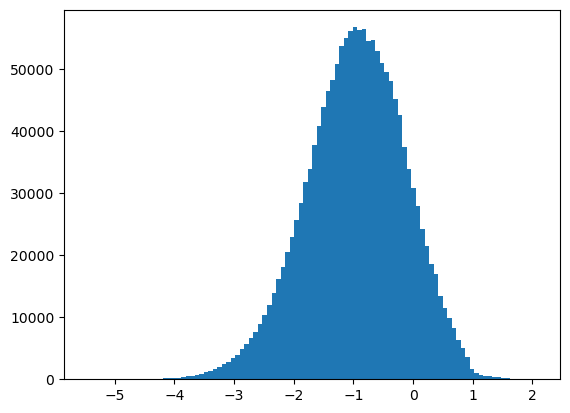

In [21]:
fig, ax = plt.subplots()
ax.hist(residuals, bins=100);

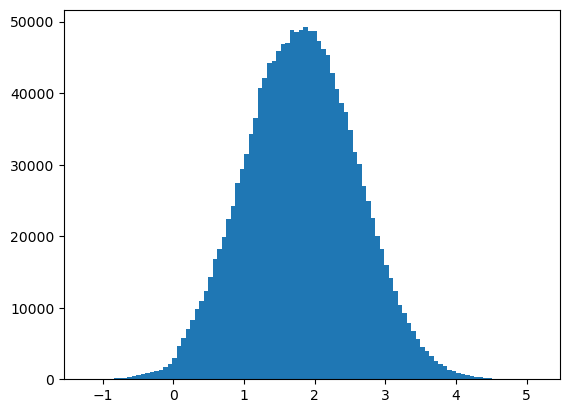

In [24]:
fig, ax = plt.subplots()
ax.hist(predict_int, bins=100);

In [22]:
for i in range(20):
    print(f"({matrix.row[i]}, {matrix.col[i]}) \tPredicted: {predict_int[i]:5.3f}, Actual: {matrix.data[i]}")

(30546, 39207) 	Predicted: 0.554, Actual: -1.0
(30546, 39409) 	Predicted: 0.605, Actual: 1.0
(30546, 39411) 	Predicted: 0.606, Actual: 1.0
(30546, 39192) 	Predicted: 0.605, Actual: 1.0
(22994, 53857) 	Predicted: 1.969, Actual: 1.0
(27127, 42845) 	Predicted: 1.211, Actual: 1.0
(10190, 42845) 	Predicted: 1.593, Actual: 1.0
(13931, 42845) 	Predicted: 1.372, Actual: 1.0
(7681, 42845) 	Predicted: 1.252, Actual: 1.0
(14363, 42845) 	Predicted: 1.772, Actual: 1.0
(20023, 391) 	Predicted: 0.062, Actual: 1.0
(7936, 42845) 	Predicted: 0.432, Actual: 1.0
(28360, 42845) 	Predicted: 0.449, Actual: 1.0
(5451, 42845) 	Predicted: 2.013, Actual: 1.0
(10086, 42845) 	Predicted: 0.162, Actual: 1.0
(1433, 8848) 	Predicted: 0.866, Actual: 1.0
(10153, 8848) 	Predicted: 1.189, Actual: -1.0
(14918, 9977) 	Predicted: 1.443, Actual: 1.0
(22330, 391) 	Predicted: 0.855, Actual: -1.0
(12714, 47943) 	Predicted: 1.598, Actual: 1.0
